<a href="https://colab.research.google.com/github/AdamKhanBM/AdamKhanBM/blob/main/InmunoF_BioLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
# Change directory to where the images are stored
os.chdir('/content/drive/My Drive/Analysis/IF/Name_of_yourfolder/')

# Verify that the current working directory is correct
print("Current working directory:", os.getcwd())

# List the files in the current directory to ensure it's correct
!ls

Mounted at /content/drive
Current working directory: /content/drive/My Drive/Programing/INMUNOFLUOR/OLL571
alexa_features_df.csv  C3_Alexa.jpg	OLL571_1_Alexa.jpg  OLL571_2_DAPI.jpg
C2_Alexa.jpg	       C3_DAPI.jpg	OLL571_1_DAPI.jpg   OLL571_3_Alexa.jpg
C2_DAPI.jpg	       features_df.csv	OLL571_2_Alexa.jpg  OLL571_3_DAPI.jpg


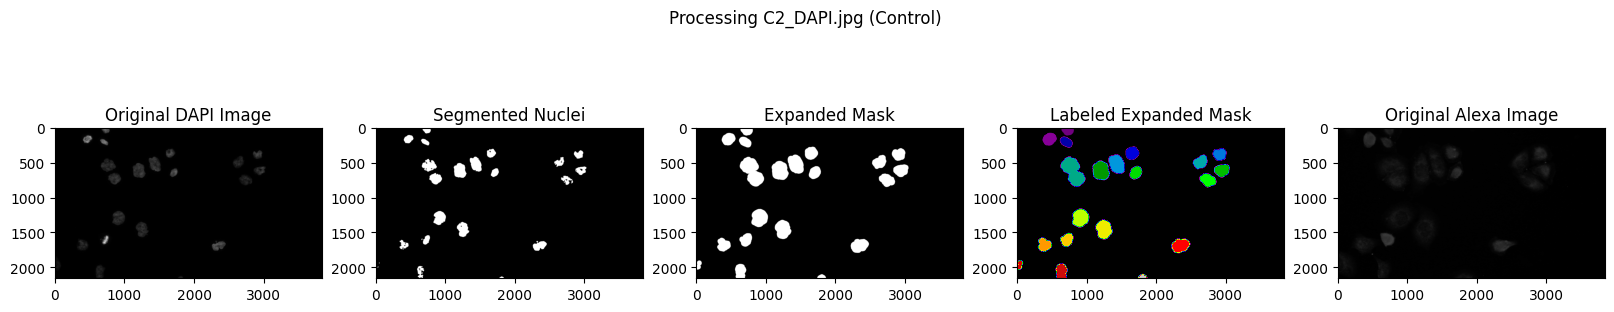

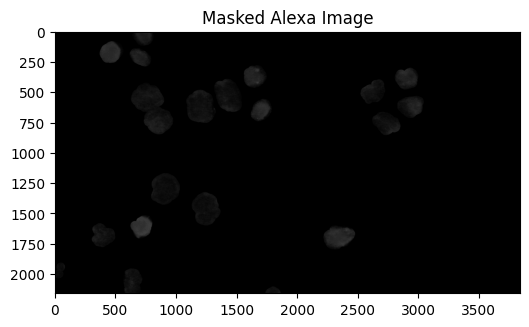

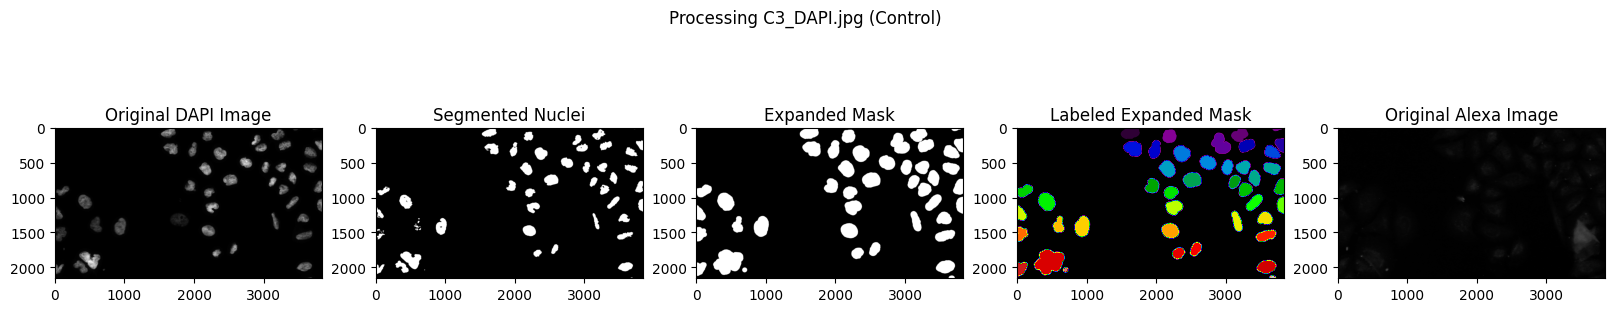

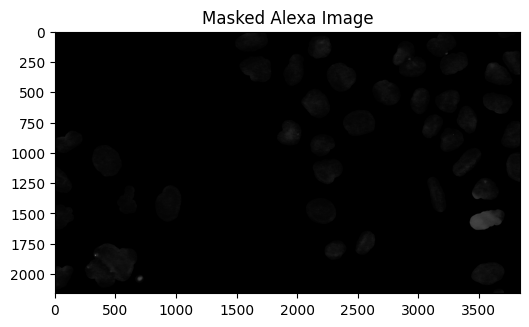

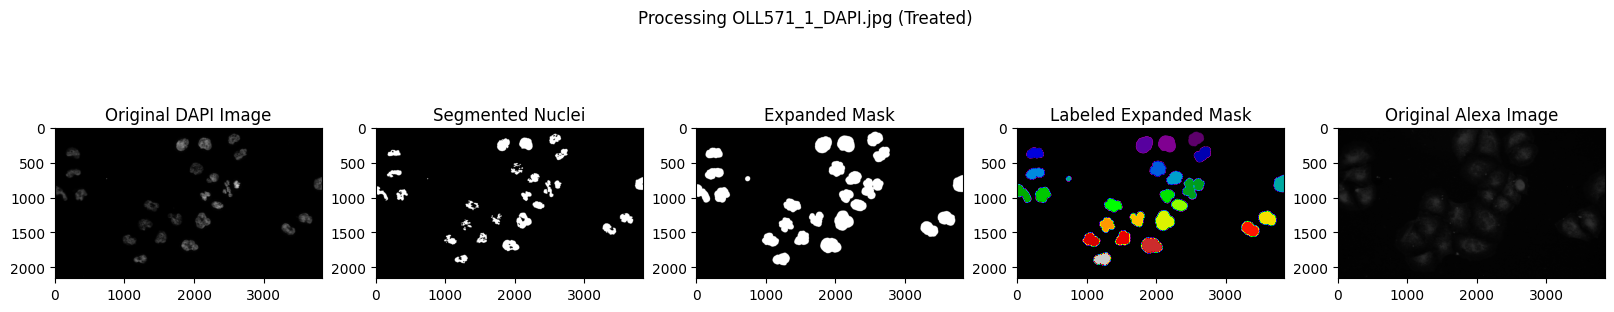

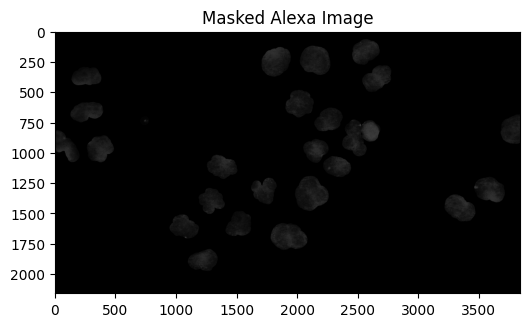

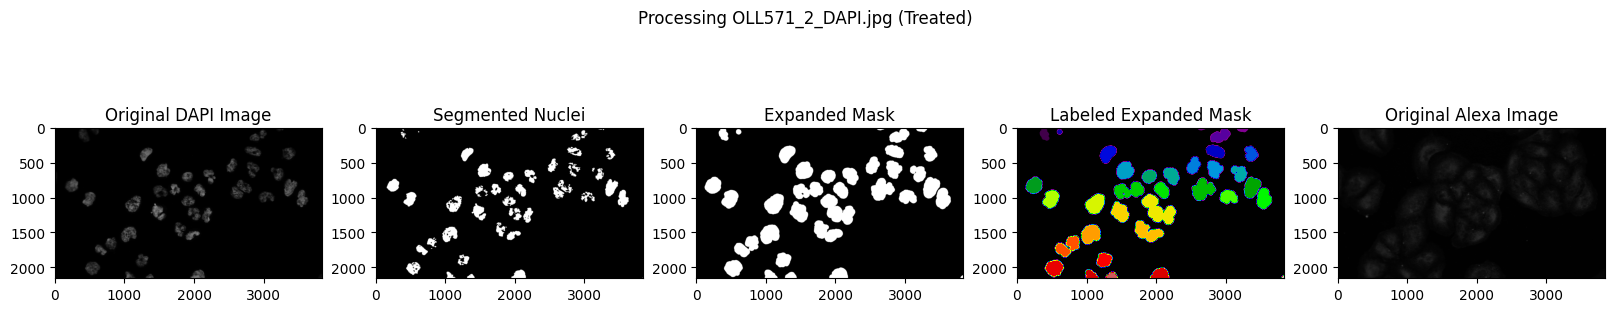

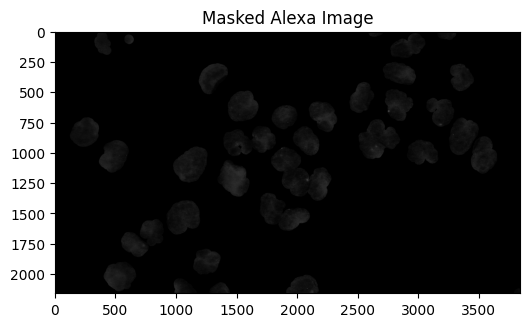

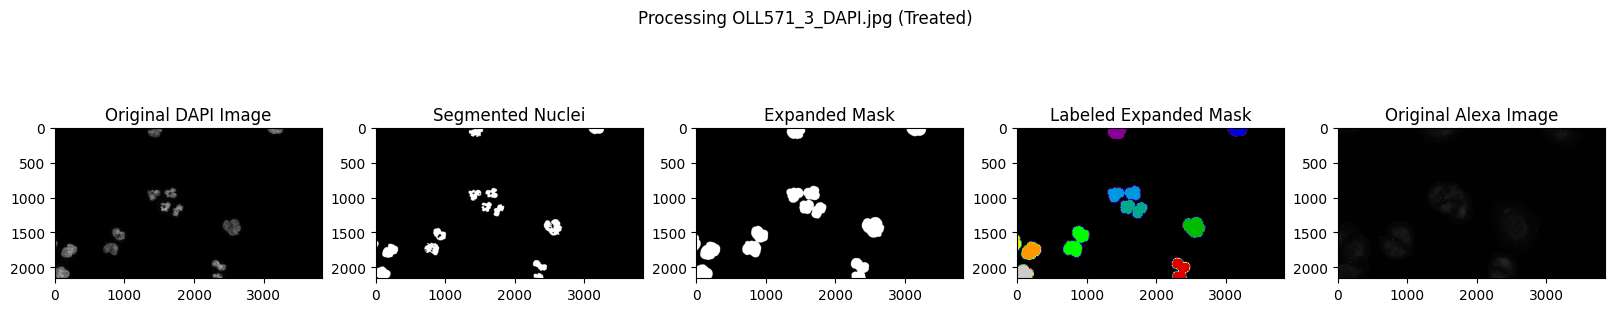

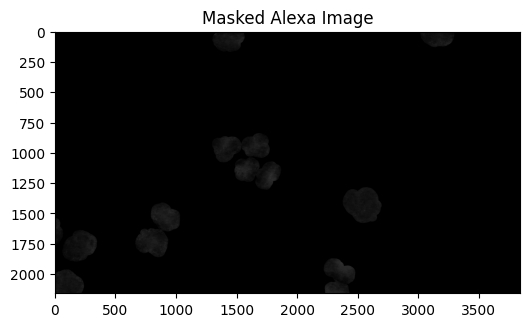

                 Image    Group  Cell Label  Cell Area  Total Intensity  \
0          C2_DAPI.jpg  Control           1    17687.0           387197   
1          C2_DAPI.jpg  Control           2    26859.0          1009954   
2          C2_DAPI.jpg  Control           3    19761.0           493810   
3          C2_DAPI.jpg  Control           4    27729.0           777328   
4          C2_DAPI.jpg  Control           5    26943.0           755559   
..                 ...      ...         ...        ...              ...   
127  OLL571_3_DAPI.jpg  Treated           6    92519.0          1677782   
128  OLL571_3_DAPI.jpg  Treated           7    10821.0           150583   
129  OLL571_3_DAPI.jpg  Treated           8    54752.0           767517   
130  OLL571_3_DAPI.jpg  Treated           9    54204.0          1062398   
131  OLL571_3_DAPI.jpg  Treated          10    39152.0           636473   

     Mean Intensity  
0         21.891615  
1         37.602070  
2         24.989120  
3         2

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import filters, morphology, measure
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects, remove_small_holes

# Set the working directory (uncomment and set your path)
# os.chdir("/Users/adamkhannavarro/Documents/Programing/Dapi cycle assay/ELZ")

# List of file names for DAPI and Alexa images
dapi_files = [
    'C2_DAPI.jpg',
    'C3_DAPI.jpg',
    'OLL571_1_DAPI.jpg',
    'OLL571_2_DAPI.jpg',
    'OLL571_3_DAPI.jpg'
]

alexa_files = [
    'C2_Alexa.jpg',
    'C3_Alexa.jpg',
    'OLL571_1_Alexa.jpg',
    'OLL571_2_Alexa.jpg',
    'OLL571_3_Alexa.jpg'
]

# Group labels for each image
# Assuming the first two images are Control and the rest are Treated
group_labels = ['Control', 'Control', 'Treated', 'Treated', 'Treated']

# Function to load images
def load_images(file_paths):
    images = []
    for file in file_paths:
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        if img is not None:
            images.append(img)
        else:
            print(f"Warning: Could not load image {file}")
    return images

# Load DAPI and Alexa images
dapi_images = load_images(dapi_files)
alexa_images = load_images(alexa_files)

# Function to preprocess images
def preprocess_image(image):
    # Apply Gaussian blur to reduce noise
    image_blurred = gaussian(image, sigma=1)
    return image_blurred

# Function to segment nuclei using improved method
def segment_nuclei(image):
    # Threshold image using Otsu's method
    thresh = filters.threshold_otsu(image)
    binary_mask = image > thresh
    # Perform morphological operations
    cleaned_mask = morphology.binary_opening(binary_mask, morphology.disk(3))
    cleaned_mask = remove_small_objects(cleaned_mask, min_size=100)
    cleaned_mask = remove_small_holes(cleaned_mask, area_threshold=100)
    return cleaned_mask.astype(np.uint8)

# Function to expand nuclei masks to approximate cell boundaries
def expand_nuclei(binary_mask, expansion_radius=30):
    # Create a structuring element for dilation
    struct_elem = morphology.disk(expansion_radius)
    expanded_mask = morphology.binary_dilation(binary_mask, struct_elem)
    return expanded_mask.astype(np.uint8)

# Initialize a list to store results
results = []

# Process each pair of DAPI and Alexa images
for idx, (dapi_img, alexa_img) in enumerate(zip(dapi_images, alexa_images)):
    # Get group label for current image
    group_label = group_labels[idx]
    image_name = dapi_files[idx]

    # Preprocess DAPI image
    preprocessed_dapi = preprocess_image(dapi_img)

    # Segment nuclei
    nuclei_mask = segment_nuclei(preprocessed_dapi)

    # Expand nuclei to approximate cell boundaries
    expanded_mask = expand_nuclei(nuclei_mask, expansion_radius=30)

    # Label the expanded mask
    labeled_mask = measure.label(expanded_mask)

    # Get properties for each labeled region (cell)
    properties = measure.regionprops(labeled_mask, intensity_image=alexa_img)

    # Collect intensity measurements for each cell
    for prop in properties:
        cell_label = prop.label
        cell_area = prop.area
        total_intensity = prop.intensity_image.sum()
        mean_intensity = prop.mean_intensity
        # You can also get other properties if needed

        results.append({
            'Image': image_name,
            'Group': group_label,
            'Cell Label': cell_label,
            'Cell Area': cell_area,
            'Total Intensity': total_intensity,
            'Mean Intensity': mean_intensity
        })

    # Optional: Visualize the segmentation and labeling process
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    axs[0].imshow(dapi_img, cmap='gray')
    axs[0].set_title('Original DAPI Image')
    axs[1].imshow(nuclei_mask, cmap='gray')
    axs[1].set_title('Segmented Nuclei')
    axs[2].imshow(expanded_mask, cmap='gray')
    axs[2].set_title('Expanded Mask')
    axs[3].imshow(labeled_mask, cmap='nipy_spectral')
    axs[3].set_title('Labeled Expanded Mask')
    axs[4].imshow(alexa_img, cmap='gray')
    axs[4].set_title('Original Alexa Image')
    plt.suptitle(f"Processing {image_name} ({group_label})")
    plt.show()

    # Optionally, visualize the masked Alexa image
    masked_alexa = np.zeros_like(alexa_img)
    masked_alexa[expanded_mask > 0] = alexa_img[expanded_mask > 0]

    plt.figure(figsize=(6, 6))
    plt.imshow(masked_alexa, cmap='gray')
    plt.title('Masked Alexa Image')
    plt.show()

# Convert results to DataFrame
features_df = pd.DataFrame(results)

# Display the DataFrame
print(features_df)

# Save the DataFrame to CSV
output_file_path = 'features_df_per_cell.csv'
features_df.to_csv(output_file_path, index=False)
print(f"DataFrame saved to {output_file_path} in the directory: {os.getcwd()}")

T-statistic: -3.8594432869051634
P-value: 0.00021523436681277324
The difference between the Control and Treated groups is statistically significant.


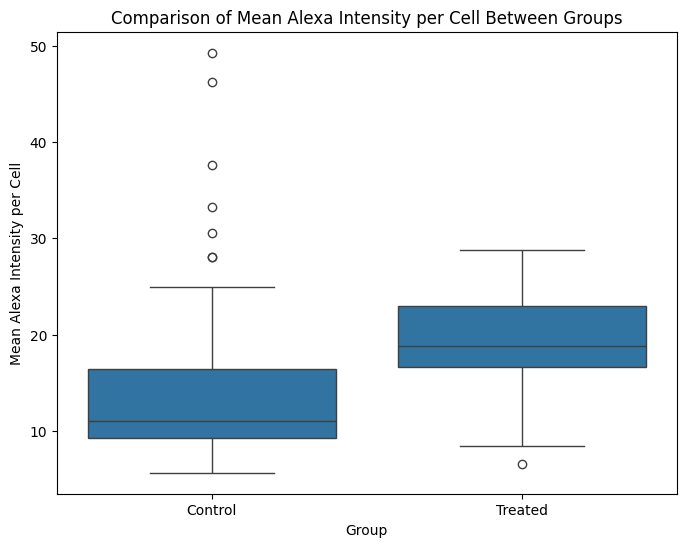

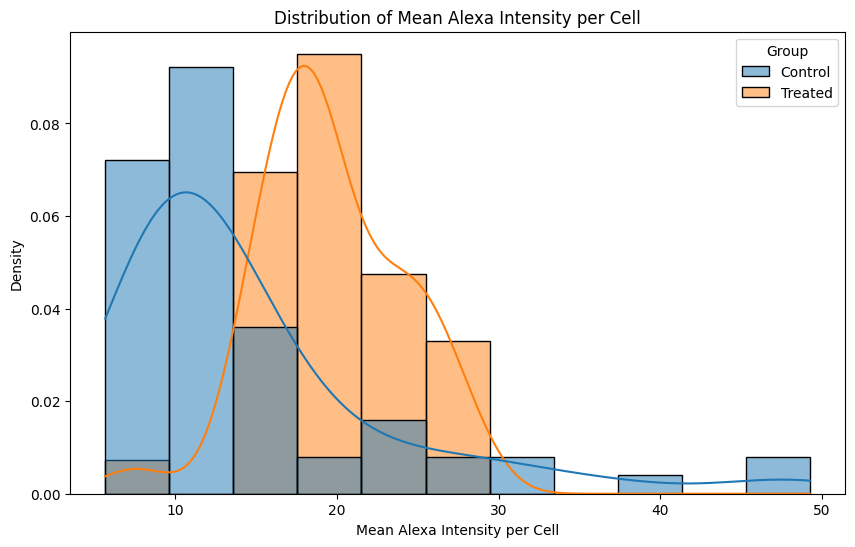

In [ ]:
# Import necessary libraries
import seaborn as sns
from scipy.stats import ttest_ind

# Read the features DataFrame if not already in memory
# features_df = pd.read_csv('features_df_per_cell.csv')

# Separate data by group
control_cells = features_df[features_df['Group'] == 'Control']
treated_cells = features_df[features_df['Group'] == 'Treated']

# Perform statistical tests, e.g., t-test on Mean Intensity
t_stat, p_value = ttest_ind(control_cells['Mean Intensity'], treated_cells['Mean Intensity'], equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("The difference between the Control and Treated groups is statistically significant.")
else:
    print("The difference between the Control and Treated groups is not statistically significant.")

# Visualization
# Boxplot of Mean Intensity per Cell
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='Mean Intensity', data=features_df)
plt.title('Comparison of Mean Alexa Intensity per Cell Between Groups')
plt.ylabel('Mean Alexa Intensity per Cell')
plt.show()

# Histogram of Mean Intensity per Cell
plt.figure(figsize=(10, 6))
sns.histplot(data=features_df, x='Mean Intensity', hue='Group', kde=True, stat="density", common_norm=False)
plt.title('Distribution of Mean Alexa Intensity per Cell')
plt.xlabel('Mean Alexa Intensity per Cell')
plt.ylabel('Density')
plt.show()

statannot library is not installed. Statistical annotations will be added manually.
T-statistic: -3.8594432869051634
P-value: 0.00021523436681277324
The difference between the Control and Treated groups is statistically significant.


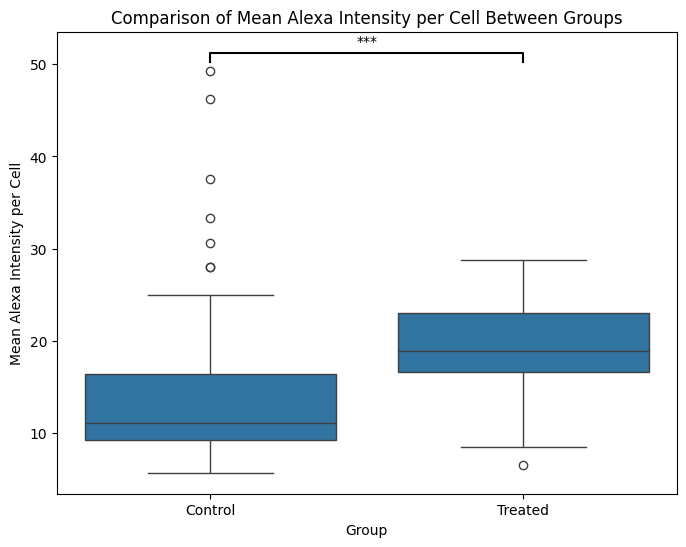

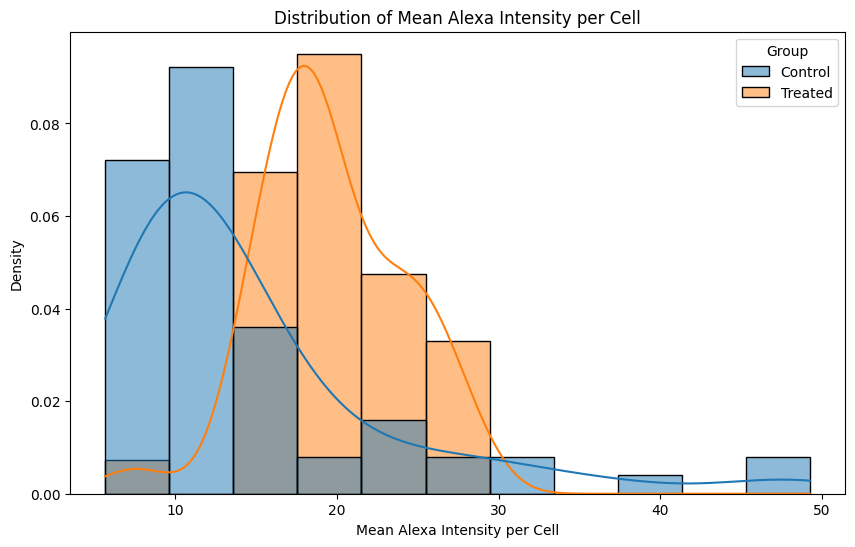

In [ ]:
# Import necessary libraries
import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np

# Install statannot if not already installed
# !pip install statannot  # Uncomment this line if running in a Jupyter notebook

try:
    from statannot import add_stat_annotation
    statannot_available = True
except ImportError:
    statannot_available = False
    print("statannot library is not installed. Statistical annotations will be added manually.")

# Read the features DataFrame if not already in memory
# features_df = pd.read_csv('features_df_per_cell.csv')

# Separate data by group
control_cells = features_df[features_df['Group'] == 'Control']
treated_cells = features_df[features_df['Group'] == 'Treated']

# Perform statistical tests, e.g., t-test on Mean Intensity
t_stat, p_value = ttest_ind(control_cells['Mean Intensity'], treated_cells['Mean Intensity'], equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("The difference between the Control and Treated groups is statistically significant.")
else:
    print("The difference between the Control and Treated groups is not statistically significant.")

# Determine significance level for annotation
if p_value < 0.001:
    significance = '***'  # p < 0.001
elif p_value < 0.01:
    significance = '**'   # p < 0.01
elif p_value < 0.05:
    significance = '*'    # p < 0.05
else:
    significance = 'ns'   # Not significant

# Visualization
# Boxplot of Mean Intensity per Cell
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x='Group', y='Mean Intensity', data=features_df)
plt.title('Comparison of Mean Alexa Intensity per Cell Between Groups')
plt.ylabel('Mean Alexa Intensity per Cell')

if statannot_available:
    # Define the pairs of groups to compare
    pairs = [('Control', 'Treated')]

    # Add statistical annotation
    add_stat_annotation(ax, data=features_df, x='Group', y='Mean Intensity',
                        box_pairs=pairs, test='t-test_ind', text_format='star',
                        loc='outside', verbose=1)
else:
    # Add statistical annotation manually
    x1, x2 = 0, 1  # Positions of the groups on the x-axis
    y, h, col = features_df['Mean Intensity'].max() + 1, 1, 'k'

    if significance != 'ns':
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((x1+x2)*0.5, y+h+0.5, significance, ha='center', va='bottom', color=col)
    else:
        plt.text((x1+x2)*0.5, y+h+0.5, 'ns', ha='center', va='bottom', color=col)

# Save the figure
plt.savefig('boxplot_mean_intensity_per_cell.png', dpi=300)
plt.show()

# Histogram of Mean Intensity per Cell
plt.figure(figsize=(10, 6))
sns.histplot(data=features_df, x='Mean Intensity', hue='Group', kde=True, stat="density", common_norm=False)
plt.title('Distribution of Mean Alexa Intensity per Cell')
plt.xlabel('Mean Alexa Intensity per Cell')
plt.ylabel('Density')

# Save the figure
plt.savefig('histogram_mean_intensity_per_cell.png', dpi=300)
plt.show()

In [ ]:
# Convert results to DataFrame
features_df = pd.DataFrame(results)

# Display the DataFrame
print(features_df)

# Save the DataFrame to CSV
output_file_path = 'features_df.csv'
features_df.to_csv(output_file_path, index=False)
print(f"DataFrame saved to {output_file_path} in the directory: {os.getcwd()}")

               Image    Group  Total Intensity  Mean Intensity
0        C2_DAPI.jpg  Control          9487952       23.125835
1        C3_DAPI.jpg  Control         10782634       12.147366
2  OLL571_1_DAPI.jpg  Treated         14419735       25.263830
3  OLL571_2_DAPI.jpg  Treated         17350844       19.127586
4  OLL571_3_DAPI.jpg  Treated          6096666       16.798833
DataFrame saved to features_df.csv in the directory: /content/drive/MyDrive/Programing/INMUNOFLUOR/OLL571


T-statistic: -0.45682720442418717
P-value: 0.7073378750670563
The difference between the Control and Treated groups is not statistically significant.


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


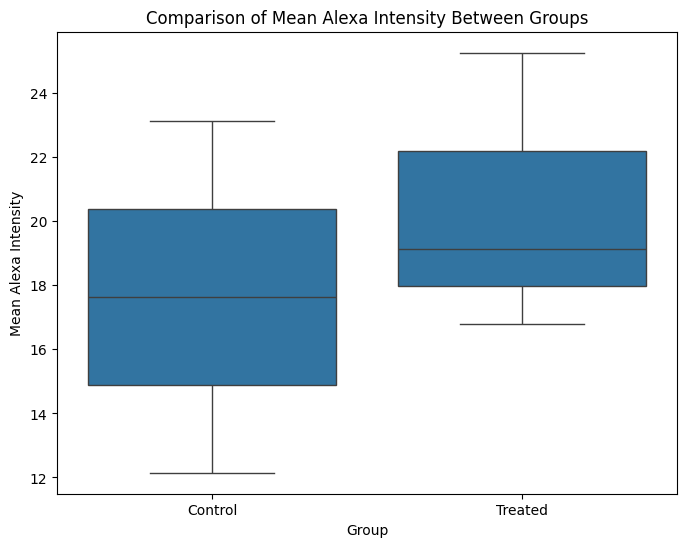

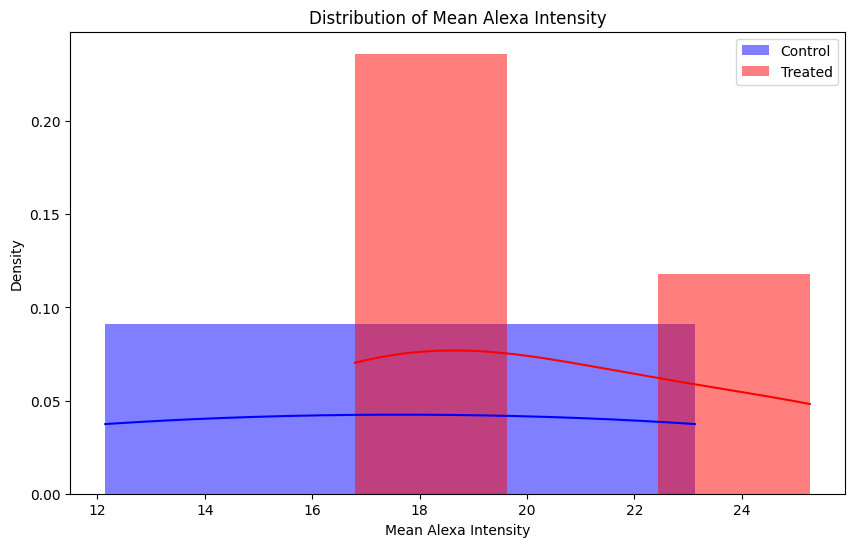

In [ ]:
# Statistical analysis
from scipy.stats import ttest_ind

# Separate the data for each group
control_data = features_df[features_df['Group'] == 'Control']['Mean Intensity']
treated_data = features_df[features_df['Group'] == 'Treated']['Mean Intensity']

# Perform t-test
t_stat, p_value = ttest_ind(control_data, treated_data, equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("The difference between the Control and Treated groups is statistically significant.")
else:
    print("The difference between the Control and Treated groups is not statistically significant.")

# Visualization
import seaborn as sns

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='Mean Intensity', data=features_df)
plt.title('Comparison of Mean Alexa Intensity Between Groups')
plt.ylabel('Mean Alexa Intensity')
plt.show()

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(control_data, color='blue', label='Control', kde=True, stat="density", linewidth=0)
sns.histplot(treated_data, color='red', label='Treated', kde=True, stat="density", linewidth=0)
plt.title('Distribution of Mean Alexa Intensity')
plt.xlabel('Mean Alexa Intensity')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



# Lists of file names for Alexa images with group labels
control_alexa_files = [
    'C2_Alexa.jpg',
    'C3_Alexa.jpg'
    # Add more control Alexa images as needed
]

treated_alexa_files = [
    'OLL571_1_Alexa.jpg',
    'OLL571_2_Alexa.jpg',
    'OLL571_3_Alexa.jpg'
    # Add more treated Alexa images as needed
]

In [ ]:
# Function to load images
def load_images(file_paths):
    images = []
    for file in file_paths:
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        if img is not None:
            images.append(img)
        else:
            print(f"Warning: Could not load image {file}")
    return images

# Load Alexa images for both groups
control_alexa_images = load_images(control_alexa_files)
treated_alexa_images = load_images(treated_alexa_files)

In [ ]:
from skimage import filters, morphology
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects, remove_small_holes, disk

# Function to preprocess images
def preprocess_image(image):
    # Apply Gaussian blur to reduce noise
    image_blurred = gaussian(image, sigma=1)
    return image_blurred

# Function to segment ROIs in Alexa images
def segment_rois(image):
    # Threshold image using Otsu's method
    thresh = filters.threshold_otsu(image)
    binary_mask = image > thresh
    # Perform morphological operations
    cleaned_mask = morphology.binary_opening(binary_mask, morphology.disk(3))
    cleaned_mask = remove_small_objects(cleaned_mask, min_size=50)
    cleaned_mask = remove_small_holes(cleaned_mask, area_threshold=50)
    return cleaned_mask.astype(np.uint8)

In [ ]:
def quantify_intensity(mask, image):
    # Ensure the mask and image have the same dimensions
    if mask.shape != image.shape:
        print("Error: Mask and image dimensions do not match.")
        return None
    # Apply the mask to the image
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    # Measure intensity within the mask
    total_intensity = np.sum(masked_image)
    mean_intensity = np.mean(masked_image[mask > 0])
    return total_intensity, mean_intensity, masked_image

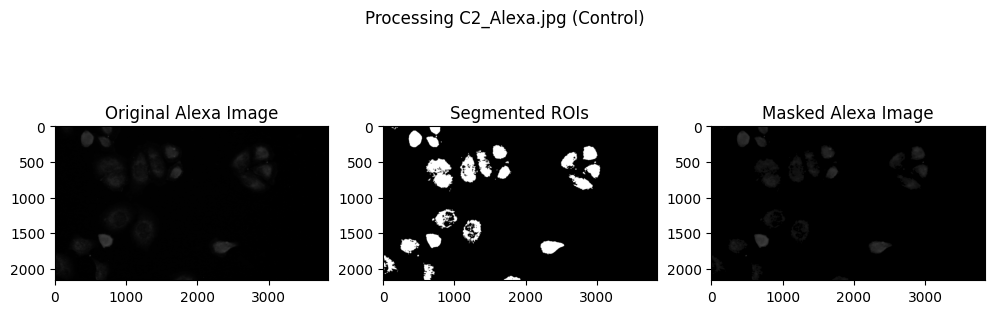

Image C2_Alexa.jpg (Control):
  Total Intensity: 15641392
  Mean Intensity: 23.471652698474628


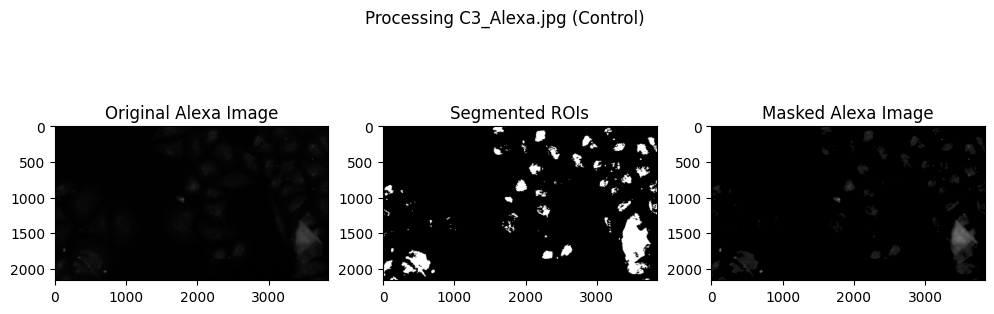

Image C3_Alexa.jpg (Control):
  Total Intensity: 12827195
  Mean Intensity: 20.720941127058616


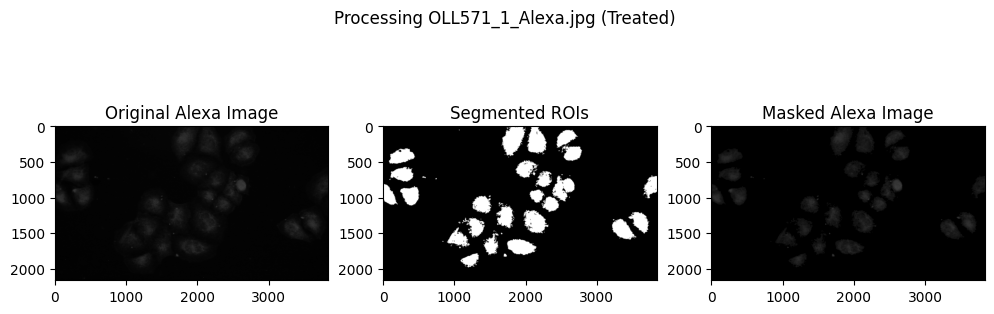

Image OLL571_1_Alexa.jpg (Treated):
  Total Intensity: 28063421
  Mean Intensity: 24.359699247337122


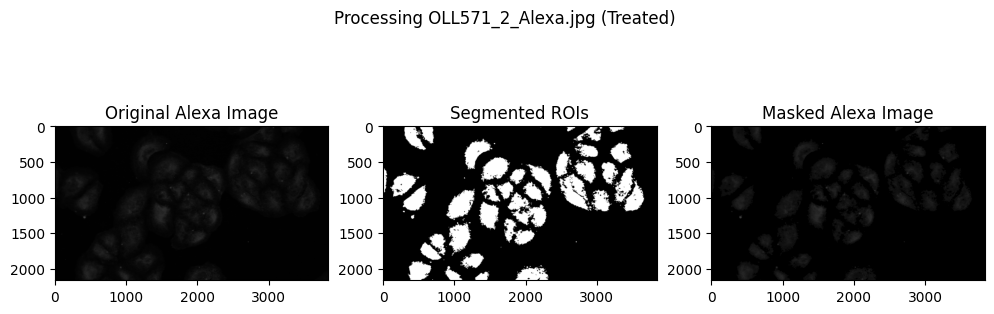

Image OLL571_2_Alexa.jpg (Treated):
  Total Intensity: 36173420
  Mean Intensity: 19.19956477316455


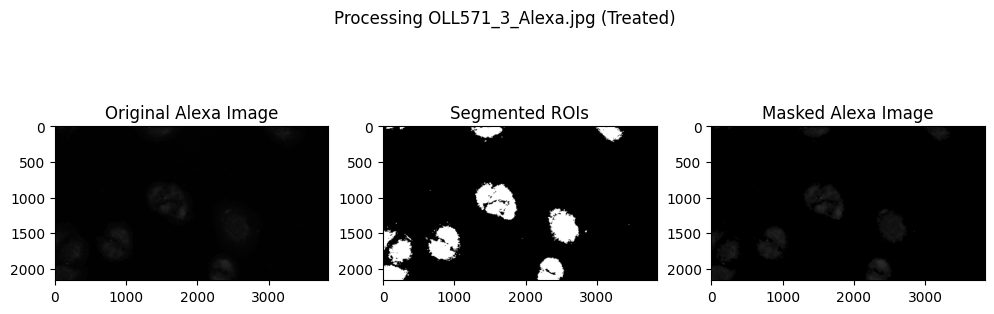

Image OLL571_3_Alexa.jpg (Treated):
  Total Intensity: 12616930
  Mean Intensity: 15.451982486757908


In [ ]:
# Initialize a list to store results
results = []

# Function to process images for a group
def process_alexa_images(alexa_images, file_names, group_label):
    for idx, (image, file_name) in enumerate(zip(alexa_images, file_names)):
        # Preprocess image
        preprocessed_image = preprocess_image(image)

        # Segment ROIs
        roi_mask = segment_rois(preprocessed_image)

        # Quantify intensity
        intensities = quantify_intensity(roi_mask, image)
        if intensities is None:
            continue
        total_intensity, mean_intensity, masked_image = intensities

        # Store results with group label
        results.append({
            'Image': file_name,
            'Group': group_label,
            'Total Intensity': total_intensity,
            'Mean Intensity': mean_intensity
        })

        # Optionally visualize the segmentation and masking process
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(image, cmap='gray')
        axs[0].set_title('Original Alexa Image')
        axs[1].imshow(roi_mask, cmap='gray')
        axs[1].set_title('Segmented ROIs')
        axs[2].imshow(masked_image, cmap='gray')
        axs[2].set_title('Masked Alexa Image')
        plt.suptitle(f"Processing {file_name} ({group_label})")
        plt.show()

        # Print intensity measurements
        print(f"Image {file_name} ({group_label}):")
        print(f"  Total Intensity: {total_intensity}")
        print(f"  Mean Intensity: {mean_intensity}")

# Process Control group
process_alexa_images(control_alexa_images, control_alexa_files, 'Control')

# Process Treated group
process_alexa_images(treated_alexa_images, treated_alexa_files, 'Treated')

In [ ]:
# Convert results to DataFrame
features_df = pd.DataFrame(results)

# Display the DataFrame
print(features_df)

# Save the DataFrame to CSV
output_file_path = 'alexa_features_df.csv'
features_df.to_csv(output_file_path, index=False)
print(f"DataFrame saved to {output_file_path} in the directory: {os.getcwd()}")

                Image    Group  Total Intensity  Mean Intensity
0        C2_Alexa.jpg  Control         15641392       23.471653
1        C3_Alexa.jpg  Control         12827195       20.720941
2  OLL571_1_Alexa.jpg  Treated         28063421       24.359699
3  OLL571_2_Alexa.jpg  Treated         36173420       19.199565
4  OLL571_3_Alexa.jpg  Treated         12616930       15.451982
DataFrame saved to alexa_features_df.csv in the directory: /content/drive/MyDrive/Programing/INMUNOFLUOR/OLL571


T-statistic: 0.8291824484422857
P-value: 0.47094472779216234
The difference between the Control and Treated groups is not statistically significant.


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


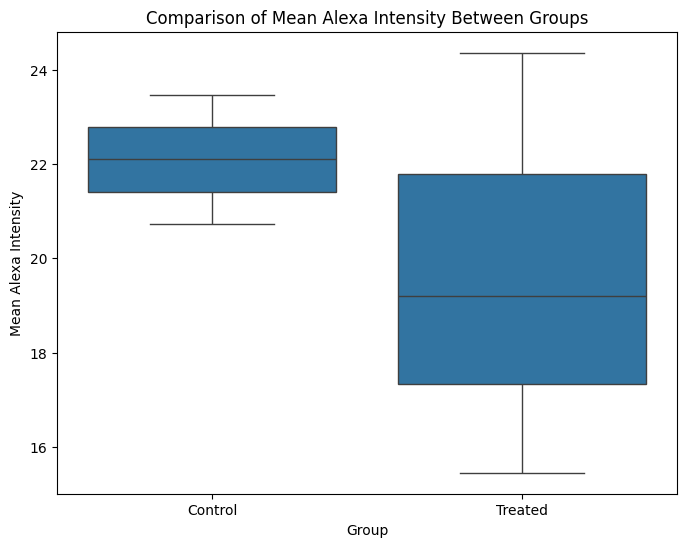

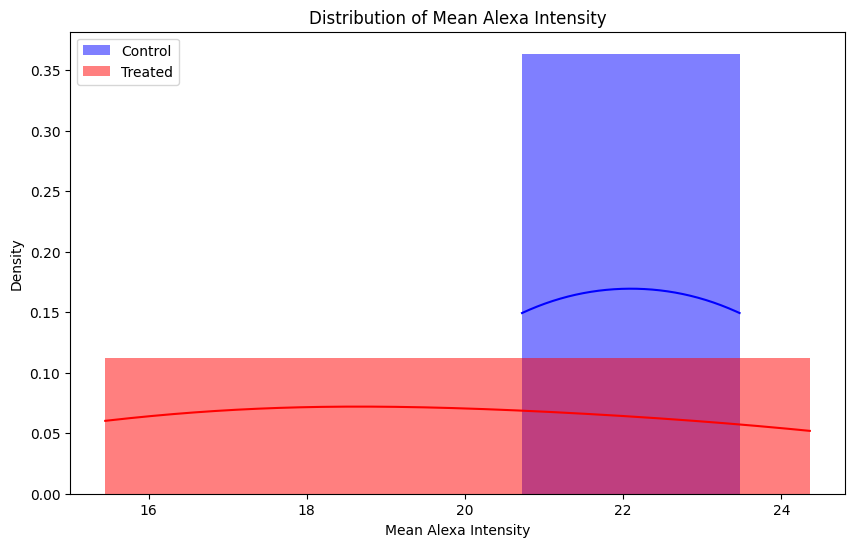

In [ ]:
# Statistical analysis
from scipy.stats import ttest_ind

# Separate the data for each group
control_data = features_df[features_df['Group'] == 'Control']['Mean Intensity']
treated_data = features_df[features_df['Group'] == 'Treated']['Mean Intensity']

# Perform t-test
t_stat, p_value = ttest_ind(control_data, treated_data, equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("The difference between the Control and Treated groups is statistically significant.")
else:
    print("The difference between the Control and Treated groups is not statistically significant.")

# Visualization
import seaborn as sns

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='Mean Intensity', data=features_df)
plt.title('Comparison of Mean Alexa Intensity Between Groups')
plt.ylabel('Mean Alexa Intensity')
plt.show()

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(control_data, color='blue', label='Control', kde=True, stat="density", linewidth=0)
sns.histplot(treated_data, color='red', label='Treated', kde=True, stat="density", linewidth=0)
plt.title('Distribution of Mean Alexa Intensity')
plt.xlabel('Mean Alexa Intensity')
plt.ylabel('Density')
plt.legend()
plt.show()